In [2]:
from ArgoData.data_centerline import Argo2Dataset
from models.ganet import get_model
from torch.utils.data import DataLoader
import torch.nn as nn
import torch

In [3]:
config, collate_fn, net, loss, post_process, opt = get_model()
# checkpoint = torch.load("./models/results/ganet1/36.000.ckpt")
# net.load_state_dict(checkpoint['state_dict'], strict = False)   
m = nn.Softmax(dim=0)

test_data = Argo2Dataset(root = '/home/user/dev/argoverse2/', split  = 'val')

test_loader = DataLoader(
    test_data,
    batch_size = 1,
    num_workers = config['val_workers'],
    shuffle = False,
    collate_fn = collate_fn,
    pin_memory=True,
)


In [75]:
for i, test_data in enumerate(test_loader):
    if i > 1:
        break
goal, out = net(test_data)
gt_preds = test_data['gt_preds']
has_preds = test_data['has_preds']
cls, reg = out["cls"], out["reg"]

In [106]:
reg[0].shape

torch.Size([21, 6, 60, 2])

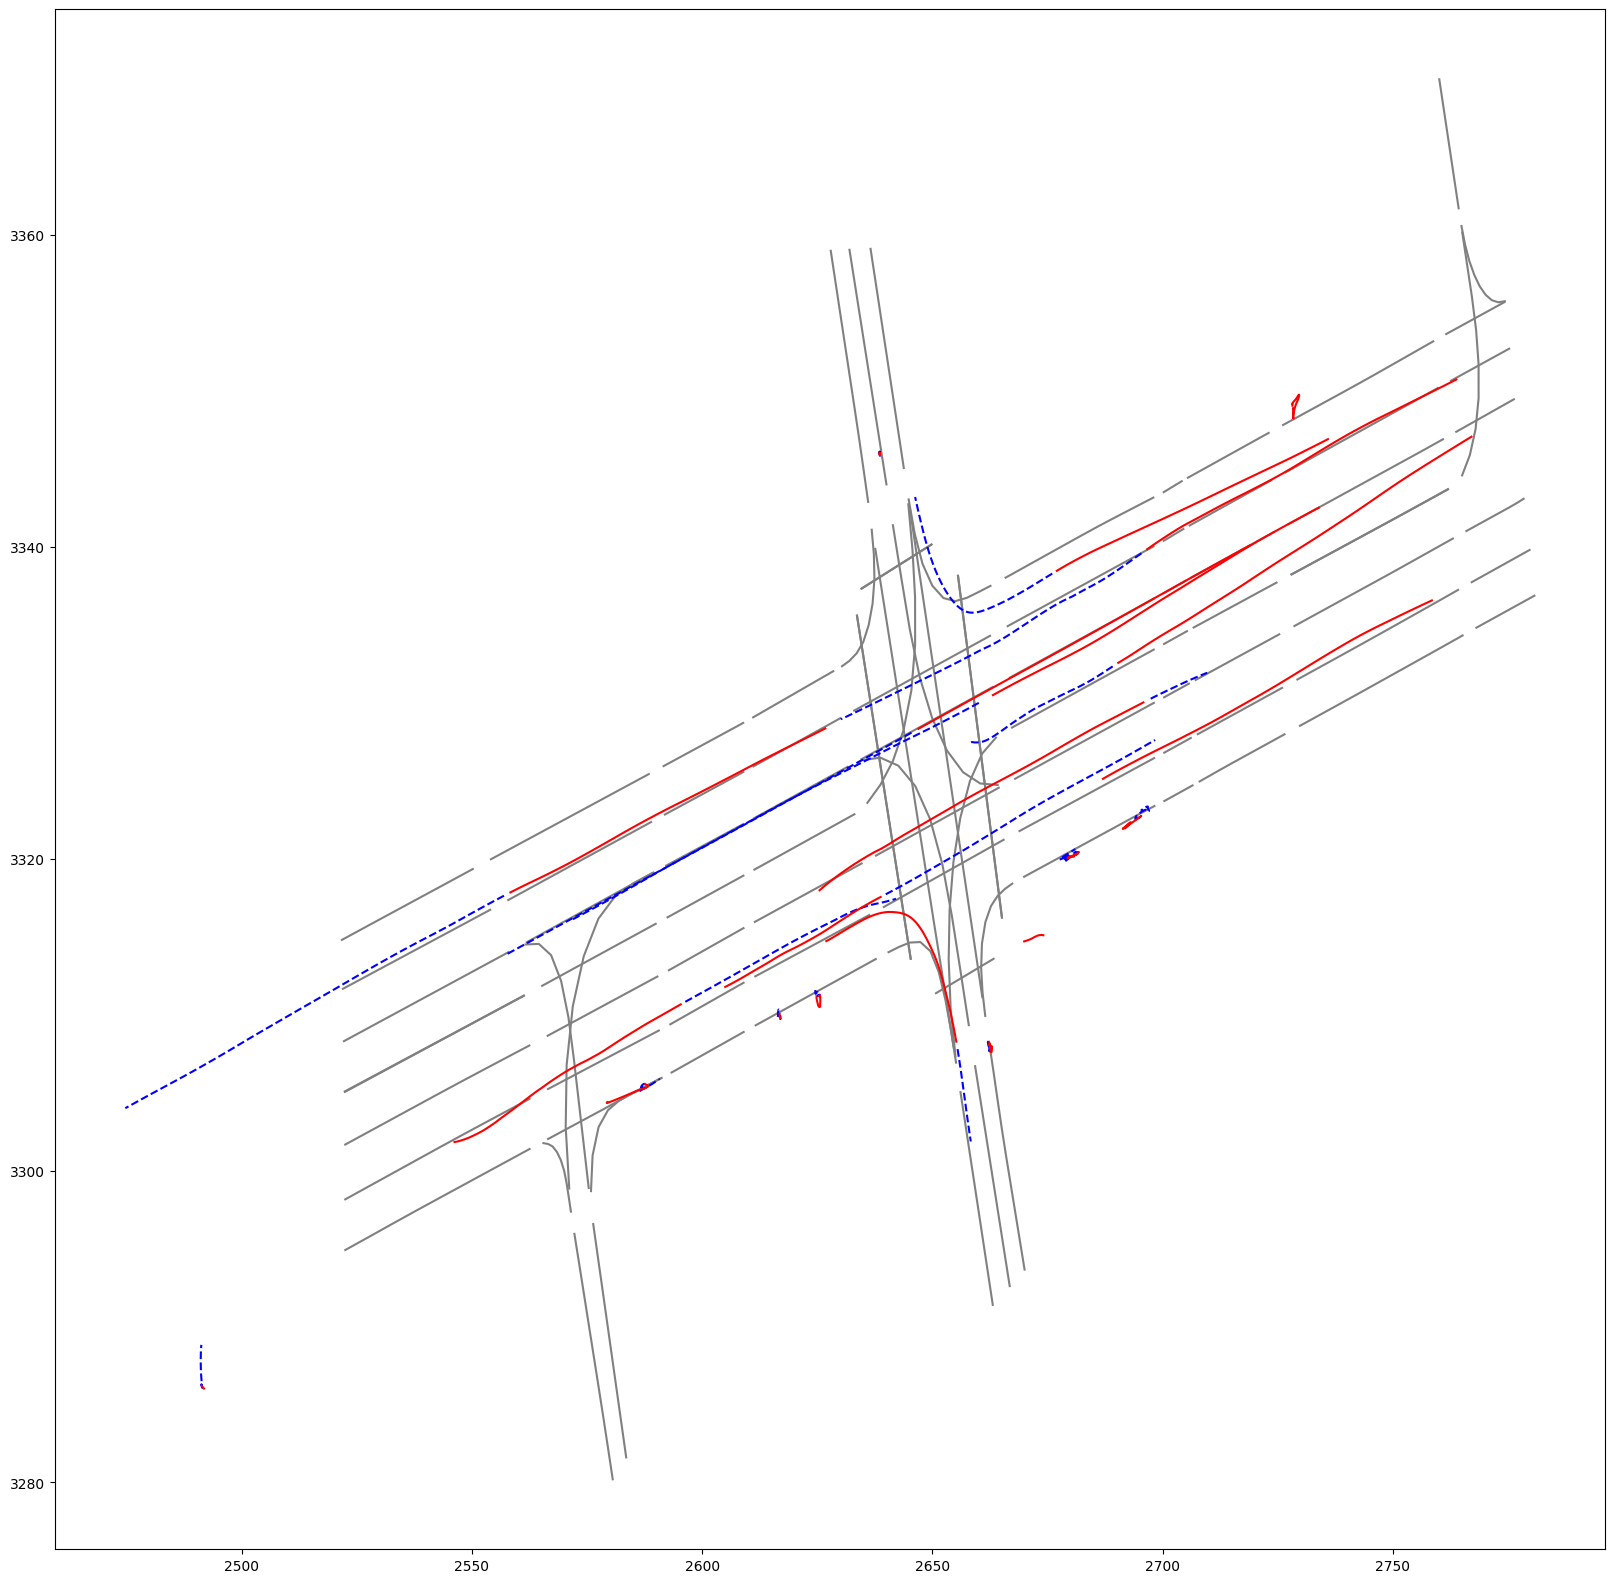

In [111]:
# set transform function
import numpy as np
import matplotlib.pyplot as plt

origin, theta = test_data["orig"][0], test_data["theta"][0]
cos, sin = np.cos(theta), np.sin(theta)
rot_mat = np.array([[np.cos(theta),  np.sin(theta)],                    # rotation matrix
                    [-np.sin(theta), np.cos(theta)]], np.float32)
rot_mat = torch.from_numpy(rot_mat.T)

# plot centerline
plt.figure(figsize=(20, 20))
for i in range(max(test_data["cl_graph"][0]["lane_idcs"])):
    lane_mask = test_data["cl_graph"][0]["lane_idcs"] == i
    curr_centerline = test_data["cl_graph"][0]["ctrs"][lane_mask]
    transformed_cl = torch.matmul(curr_centerline, rot_mat) + origin
    plt.plot(transformed_cl[:, 0], transformed_cl[:, 1], color = "grey")

# plot agent future gt
for agent_fut_traj in gt_preds[0]:
    valid_points = agent_fut_traj[agent_fut_traj[:, 0] != 0]
    plt.plot(valid_points[:, 0], valid_points[:, 1], color = "blue", linestyle = "--")

for hist in test_data["hist"][0]:
    valid_points = hist[hist[:, 0] != 0]
    transformed_cl = torch.matmul(valid_points, rot_mat) + origin
    plt.plot(transformed_cl[:, 0], transformed_cl[:, 1], color = "red")

# plot your predictions 
# for curr_agent in reg[0].detach().cpu().numpy():
#     for curr_mode in curr_agent:
#         plt.plot(curr_mode[:, 0], curr_mode[:, 1], color = "purple")